In [5]:

import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.sparse import coo_matrix
from scipy import linalg
import math
import cProfile
import re
from functools import partial
import multiprocessing
from multiprocessing import Pool
import sys

def compute_average_pmf(args):
    rbn_instance, r, num_T = args
    network = rbn_instance
    combined_pmf = np.zeros(2 ** network.N)
    for _ in range(num_T):
        network.generate_logic_tables(r)
        initial_vector, sparse_matrix = network.create_initial_vector_and_sparse_matrix()
        pmf = network.find_stationary_distribution(initial_vector, sparse_matrix, tolerance=1e-8)
        combined_pmf += pmf
    average_pmf = combined_pmf / num_T
    return average_pmf

class RBN:
    def __init__(self, K, N, r):
        self.K = K  # Number of inputs per node
        self.N = N  # Number of nodes in the network
        self.r = r  # Flip probability
        self.G = nx.DiGraph()
        self.initialization()
        self.generate_logic_tables(self.r)

    def initialization(self):
        #Accounting for the fact that the function deletes half of the nodes
        self.K = 2 * (self.K)
        expected_degrees = [self.K for _ in range(self.N)]
        self.G = nx.expected_degree_graph(expected_degrees, selfloops=False)
        self.G = nx.DiGraph(self.G)
        for u, v in list(self.G.edges()):
            if random.random() < 0.5:
                self.G.remove_edge(u, v)
                self.G.add_edge(v, u)
        for i in range(self.N):
            self.G.nodes[i]["state"] = random.choice([True, False])

    def generate_logic_tables(self, r):
        for i in self.G.nodes:
            inputs = list(self.G.predecessors(i))
            truth_table = [random.random() < r for _ in range(2 ** len(inputs))]
            self.G.nodes[i]["inputs"] = inputs
            self.G.nodes[i]["truth_table"] = truth_table

    # this function is used in Fisher
    def modify_logic_tables(self, increment_prob):
        for i in self.G.nodes:
            truth_table = self.G.nodes[i]["truth_table"]
            for j in range(len(truth_table)):
                if random.random() < increment_prob:
                    truth_table[j] = not truth_table[j]
            self.G.nodes[i]["truth_table"] = truth_table

    def bin_to_dec(self, bin_list):
        return np.dot(bin_list, 2 ** np.arange(len(bin_list))[::-1])

    def dec_to_bin(self, dec):
        bin_list = [False] * self.N
        binary_repr = bin(dec)[2:]

        for i in range(len(binary_repr)):
            bin_list[self.N - len(binary_repr) + i] = bool(int(binary_repr[i]))

        return bin_list

    def bin_to_bin_str(self, bin_list):
        bin_str = ''.join(['1' if b else '0' for b in bin_list])
        return bin_str

    def step(self, show_plot=False):
        new_state = []
        for node in self.G.nodes:
            inputs = self.G.nodes[node]["inputs"]
            truth_table = self.G.nodes[node]["truth_table"]
            input_vals = [self.G.nodes[input]["state"] for input in inputs]
            index = self.bin_to_dec(input_vals)
            output = truth_table[index]
            new_state.append(output)

        for i, state in enumerate(new_state):
            self.G.nodes[i]["state"] = state

    def plot_states(self):
        color_map = {True: 'blue', False: 'red'}
        colors = [color_map[self.G.nodes[node]["state"]] for node in self.G.nodes()]
        nx.draw(self.G, with_labels=True, node_color=colors, font_weight='bold')
        plt.show()

    def create_initial_vector_and_sparse_matrix(self):
        num_states = 2 ** (self.N)
        initial_vector = np.ones(num_states) / num_states

        row_indices = np.zeros(num_states, dtype=int)
        col_indices = np.zeros(num_states, dtype=int)

        # for the first state: I initialize my network in that state
        # (I need a dec to bin for that, given the number of nodes I have, and then make a step.
        # I record where I am then using dec to bin. Lets experiment with n=5.

        # just try it once. state ito F,T
        after_step = np.zeros(self.N)
        for k in range(num_states):
            Network_state = self.dec_to_bin(k)
            # now manipulating the nodes. The network is already initialized
            for i in range(self.N):
                self.G.nodes[i]["state"] = Network_state[i]
                # print("before",Network_state[i])
            self.step()
            for i in range(self.N):
                after_step[i] = self.G.nodes[i]["state"]
                # print("äfter", after_step[i])

            # order row/column: https://brilliant.org/wiki/markov-chains/#markov-chain
            # the row indice is the before step, which is simply the index of the initial vector. although it feels weird
            # I changed it now and it works now.
            row_indices[k] = self.bin_to_dec(after_step)
            col_indices[k] = k
            # print("bin to dec",k, self.bin_to_dec(after_step) )

            # there is only one data point per column/row. so after this we can go to the next one. but it does that automatically.
            # Create a transition matrix after all steps
        data = np.ones(num_states)
        transition_matrix = coo_matrix((data, (row_indices, col_indices)), shape=(num_states, num_states))
        # print(transition_matrix)
        # I do this for all states. I need to be careful:
        # to be a bit more efficient: I just need to take my "before step" initialization, and only change the nodes that need to changes.

        return initial_vector, transition_matrix

    def find_stationary_distribution(self, initial_vector, transition_matrix, tolerance, num_iterations=100):
        probability_vector = initial_vector

        for i in range(num_iterations):
            probability_vector_i = transition_matrix * probability_vector
            if np.allclose(probability_vector_i, probability_vector, atol=tolerance):
                probability_vector = probability_vector_i
                return probability_vector

            probability_vector = probability_vector_i

        return probability_vector

    # Put the Fisher Characteristica here
    # steps:
    # 1. see how to implement the pmf
    # pmf for different r? How does one do that? Just run the RBN different times? that should shange nothing in the code for Markov itself
    # important to run enough times
    # plotting? Is the easy part, already implemented

    def filter_pmf_and_compare(self, pmf, pmf_prev, threshold):
        num_states = len(pmf)
        log_pmf = np.where(pmf == 0, 0, np.log(pmf))
        log_pmf_prev = np.where(pmf_prev == 0, 0, np.log(pmf_prev))
        log_diff = np.abs(log_pmf - log_pmf_prev)

        filtered_pmf = np.where(log_diff >= threshold, pmf, 0)
        result = np.where(log_diff >= threshold, log_diff, 0)

        return result, filtered_pmf

    def compute_Fisher(self, d_r, num_T, threshold, n_processes=None):
        N = self.N
        num_states = 2 ** N
        F = 0
        F_array = np.zeros(len(np.arange(0, 1 + d_r, d_r)))
        r_values = np.arange(0, 1 + d_r, d_r)

        # Use multiprocessing.Pool to calculate average pmf for each r value
        with Pool(processes=n_processes) as pool:
            pmf_stack = np.array(pool.map(compute_average_pmf, [(self, r, num_T) for r in r_values]))

        pmf_stack = pmf_stack.T
        num_columns = pmf_stack.shape[1]
        assert num_columns == int(1 / d_r) + 1, f'{num_columns=}'
        t = 0
        for column_index in range(1, num_columns):
            column_1 = pmf_stack[:, column_index]
            column_0 = pmf_stack[:, column_index - 1]
            result, filtered_pmf = self.filter_pmf_and_compare(column_1, column_0, threshold)

            for j in range(len(result)):
                result_value = result[j]
                filtered_pmf_value = filtered_pmf[j]

                F += (filtered_pmf_value * ((result_value / d_r) ** 2))
            F_array[t + 1] = F
            F = 0

            t = t + 1

        F_array[-1] = 0
        return F_array

def Fisher_plot(d_r, num_T, threshold, num_processes, network):
    # Calculate Fisher information array
    F_array = network.compute_Fisher(d_r, num_T, threshold, num_processes)

    # Plot F_array against the equally spaced values
    x_values = np.linspace(0, 1, len(F_array))
    plt.plot(x_values, F_array, marker='o', linestyle='-')
    plt.xlabel('x values')
    plt.ylabel('F_array values')
    plt.title('Values of Fisher information plotted between 0 and 1')
    plt.grid(True)
    # plt.savefig(r'C:\Users\emiel\OneDrive\Bureaublad\Capstone_g\figure.png')
    # sys.exit("Stopping the code execution.")
    plt.show()
    
def one_barplot(network, r, num_T, d_r):
    # a bar plot with how much the pmf changes for a certtain r +dr
    args = (network, r, num_T)
    # categories = ['0.1', '0.1+d_r', '0.5', '0.5+d_r']
    categories = ['0.1+d_r', '0.5+d_r']
    num_compare = 2
    values = np.zeros(num_compare)
    r = 0.1
    average_pmf = compute_average_pmf(args)
    r = 0.1 + d_r
    average1_pmf = compute_average_pmf(args)
    values[0] = np.linalg.norm(average1_pmf - average_pmf)
    r = 0.5
    average_pmf = compute_average_pmf(args)
    r = 0.5 + d_r
    average1_pmf = compute_average_pmf(args)
    values[1] = np.linalg.norm(average1_pmf - average_pmf)

    # if I want to know susceptability, I should measure the difference between eg 0.5 and 0.5 +dr. you can use the function for it
    plt.bar(categories, values, color=['red', 'blue'])
    plt.xlabel('Values of r')
    plt.ylabel('Differences')
    plt.title('The change of pmf per r')
    plt.show()

def convergence(num_T, N, network,r):
    # extra part, maybe soon in jupyter notebook
    # showing that
    resvec = np.zeros(num_T)
    combined_pmf = np.zeros(2 ** N)
    combined_pmf_prev = np.zeros(2 ** N)
    for i in range(num_T):
        network.generate_logic_tables(r)
        initial_vector, sparse_matrix = network.create_initial_vector_and_sparse_matrix()
        pmf = network.find_stationary_distribution(initial_vector, sparse_matrix, tolerance=1e-8)
        combined_pmf += pmf
        combined_pmf /= 2
        resvec[i] = np.linalg.norm(combined_pmf - combined_pmf_prev)
        combined_pmf_prev = combined_pmf

    iteration = np.linspace(0, num_T - 1, num_T)
    plt.plot(iteration, resvec, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Error convergence')
    plt.grid(True)
    plt.show()
def pmf_barplot(network, r, num_T, d_r, ):
 # the upgraded bar plot with 2**N  times two bars

    args = (network, r, num_T)
    r = 0.1
    average_pmf = compute_average_pmf(args)
    r = 0.1 + d_r
    average1_pmf = compute_average_pmf(args)
    num_states = len(average_pmf)
    X_axis = np.arange(num_states)

    bar_width = 0.4
    plt.bar(X_axis - bar_width / 2, average_pmf, bar_width, label='0.1')
    plt.bar(X_axis + bar_width / 2, average1_pmf, bar_width, label='0.1 + d_r')

    plt.xticks(X_axis, X_axis)  # Use system states as x-axis labels
    plt.xlabel('System States (Decimal Value)')
    plt.ylabel('PMF')
    plt.title('PMF values for 0.1 and 0.1 + dr')
    plt.legend()
    plt.show()

    #The same, but for 0.5

    args = (network, r, num_T)
    r = 0.5
    average_pmf = compute_average_pmf(args)
    r = 0.5 + d_r
    average1_pmf = compute_average_pmf(args)

    num_states = len(average_pmf)
    X_axis = np.arange(num_states)

    bar_width = 0.4
    plt.bar(X_axis - bar_width / 2, average_pmf, bar_width, label='0.5')
    plt.bar(X_axis + bar_width / 2, average1_pmf, bar_width, label='0.5 + d_r')

    plt.xticks(X_axis, X_axis)  # Use system states as x-axis labels
    plt.xlabel('System States (Decimal Value)')
    plt.ylabel('PMF')
    plt.title('PMF values for 0.5 and 0.5 + dr')
    plt.legend()
    plt.show()

def sorted_pmf_plot(network, r, num_T, d_r):
    # Soring the pmf arrays and making a line pot

    args = (network, r, num_T)
    r = 0.1
    average_pmf = compute_average_pmf(args)
    average_pmf.sort()
    r = 0.1 + d_r
    average1_pmf = compute_average_pmf(args)
    average1_pmf.sort()

    num_states = len(average_pmf)
    X_axis = np.arange(num_states)
    plt.plot(X_axis, average_pmf, label='r=0.1', linestyle='-', marker='o')
    plt.plot(X_axis, average1_pmf, label='r=0.1 + d_r', linestyle='-', marker='o')
    # Fill the area under the curves
    plt.fill_between(X_axis, average_pmf, alpha=0.2)
    plt.fill_between(X_axis, average1_pmf, alpha=0.2)

    plt.xlabel('System States (Decimal Value)')
    plt.ylabel('PMF')
    plt.title('Sorted PMF values for 0.1 and 0.1 + dr')
    plt.legend()
    plt.show()

    # Now for 0.5

    args = (network, r, num_T)
    r = 0.5
    average_pmf = compute_average_pmf(args)
    average_pmf.sort()
    r = 0.5 + d_r
    average1_pmf = compute_average_pmf(args)
    average1_pmf.sort()

    num_states = len(average_pmf)
    X_axis = np.arange(num_states)
    plt.plot(X_axis, average_pmf, label='r=0.5', linestyle='-', marker='o')
    plt.plot(X_axis, average1_pmf, label='r=0.5 + d_r', linestyle='-', marker='o')
    # Fill the area under the curves
    plt.fill_between(X_axis, average_pmf, alpha=0.2)
    plt.fill_between(X_axis, average1_pmf, alpha=0.2)

    plt.xlabel('System States (Decimal Value)')
    plt.ylabel('PMF')
    plt.title('Sorted PMF values for 0.1 and 0.1 + dr')
    plt.legend()
    plt.show()

def print_pmf(network, N):
    # Call the function to create the initial probability vector and sparse matrix
    initial_vector, sparse_matrix = network.create_initial_vector_and_sparse_matrix()

    # Call the function to find the stationary distribution (pmf) using power iteration
    pmf = network.find_stationary_distribution(initial_vector, sparse_matrix, tolerance=1e-8)
    # pmf_eig=(network.find_steady_state_eig(sparse_matrix)/(2**N))
    p_sum = 0
    for i in range(2 ** N):
        if pmf[i] > 0.0001:
            p_sum = p_sum + pmf[i]
            print("p(", network.bin_to_bin_str(network.dec_to_bin(i)), ") :", pmf[i])
    print("Probability sum:", p_sum)



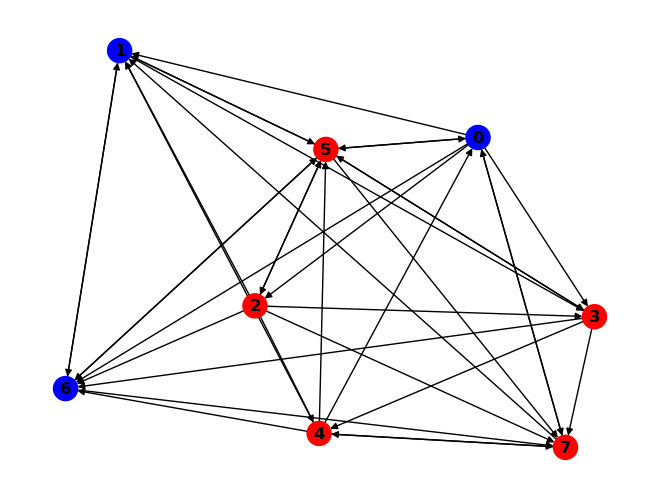

p( 00111010 ) : 0.08203125
p( 01011111 ) : 0.05078125
p( 10101011 ) : 0.015625
p( 10111000 ) : 0.109375
p( 10111011 ) : 0.0859375
p( 10111111 ) : 0.04296875
p( 11001101 ) : 0.01171875
p( 11111100 ) : 0.6015625
Probability sum: 1.0


In [6]:
def main():   
    K = 6

    N = 8
    r = 0.6
    threshold = 0
    d_r = 0.05
    num_T = 10
    num_processes = 4

    # Create an instance of the RBN class with 4 inputs per node, 10 nodes, and r=0.6
    network = RBN(K, N, r)
    # Create an instance of the RBN class with 4 inputs per node, 10 nodes, and r=0.6 K= 6
    network.plot_states()
    print_pmf(network, N)
if __name__ == "__main__":
    main()



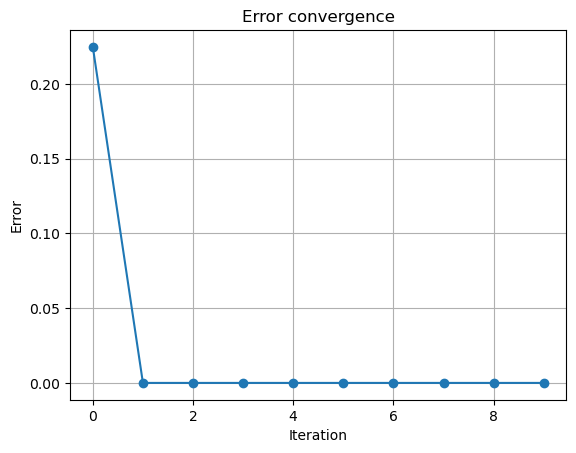

In [7]:
def main():   
    K = 6

    N = 8
    r = 0.6
    threshold = 0
    d_r = 0.05
    num_T = 10
    num_processes = 4

    # Create an instance of the RBN class with 4 inputs per node, 10 nodes, and r=0.6
    network = RBN(K, N, r)
    # Create an instance of the RBN class with 4 inputs per node, 10 nodes, and r=0.6 K= 6
    convergence(num_T, N, network, r)
if __name__ == "__main__":
    main()


In [ ]:
def main():   
    K = 6

    N = 8
    r = 0.6
    threshold = 0
    d_r = 0.05
    num_T = 10
    num_processes = 4

    # Create an instance of the RBN class with 4 inputs per node, 10 nodes, and r=0.6
    network = RBN(K, N, r)
    # Create an instance of the RBN class with 4 inputs per node, 10 nodes, and r=0.6 K= 6
    Fisher_plot(d_r, num_T, threshold, num_processes, network)
    one_barplot(network, r, num_T, d_r)
    pmf_barplot(network, r, num_T, d_r)
    sorted_pmf_plot(network, r, num_T, d_r)
if __name__ == "__main__":
    main()
